### Libraries

In [7]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from itertools import chain, combinations
from collections import Counter
from tqdm import tqdm
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

# NLTK Imports
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer

#Scikit-learn Imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

import xgboost as xgb
from textblob import TextBlob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from datasets import load_dataset
import string
import matplotlib.pyplot as plt
import results_and_fixtures
import plotly.graph_objects as go
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

tqdm.pandas()

pd.set_option('display.max_colwidth', 50)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tkoun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tkoun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tkoun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tkoun\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Loading the data

In [216]:
### Article Data
df = pd.read_csv('bbc_football_articles_full.csv')

In [217]:
### Results and Fixtures
data = results_and_fixtures.scrape_data()
data = data.dropna(subset=['Score'])

Obtaining the data...
Loading the data...


## Preprocessing for Fixtures and Results

In [219]:
#Assigning each match with a match ID
data["MatchID"] = range(1, len(data) + 1)


#Split each match into two rows so that we can attach later on the articles to each team

#Home row
home = data.assign(
    Team=data["Home"],
    Opponent=data["Away"],
    xG_for=data["xG"],
    HomeAway=1
)[["MatchID", "Date", "Time", "Team", "Opponent", "HomeAway", "xG_for", "Score", "Venue", "Referee"]]

#Away row
away = data.assign(
    Team=data["Away"],
    Opponent=data["Home"],
    xG_for=data["xG.1"],
    HomeAway=0
)[["MatchID", "Date", "Time", "Team", "Opponent", "HomeAway", "xG_for", "Score", "Venue", "Referee"]]

#Combine into a single dataset
data = pd.concat([home, away], ignore_index=True).sort_values("MatchID")

#Renaming Nottingham Forest
data[data == "Nott'ham Forest"] = "Nottingham"

In [220]:
data

,MatchID,Date,Time,Team,Opponent,HomeAway,xG_for,Score,Venue,Referee
0,1,2025-08-15,20:00 (22:00),Liverpool,Bournemouth,1,2.2,4–2,Anfield,Anthony Taylor
130,1,2025-08-15,20:00 (22:00),Bournemouth,Liverpool,0,1.7,4–2,Anfield,Anthony Taylor
1,2,2025-08-16,12:30 (14:30),Aston Villa,Newcastle Utd,1,0.2,0–0,Villa Park,Craig Pawson
131,2,2025-08-16,12:30 (14:30),Newcastle Utd,Aston Villa,0,1.4,0–0,Villa Park,Craig Pawson
2,3,2025-08-16,15:00 (17:00),Sunderland,West Ham,1,0.7,3–0,Stadium of Light,Robert Jones
...,...,...,...,...,...,...,...,...,...,...
127,128,2025-11-30,14:05 (16:05),Aston Villa,Wolves,1,0.9,1–0,Villa Park,Chris Kavanagh
258,129,2025-11-30,14:05 (16:05),Liverpool,West Ham,0,1.2,0–2,London Stadium,Darren England
128,129,2025-11-30,14:05 (16:05),West Ham,Liverpool,1,0.3,0–2,London Stadium,Darren England
129,130,2025-11-30,16:30 (18:30),Chelsea,Arsenal,1,0.8,1–1,Stamford Bridge,Anthony Taylor


In [221]:
#Creating a column showing if the team won/draw/loss
def get_result(row):
    score = row['Score']

    #If score is missing, return None
    if pd.isna(score):
        return None

    #Convert to string
    score = str(score)

    #Normalize separators 
    score = score.replace('–', '-')

    #Validate expected format
    if '-' not in score:
        return None

    try:
        home, away = map(int, score.split('-'))
    except:
        return None

    #Determine result based on Home/Away
    if row['HomeAway'] == 1:  # Home match
        if home > away: return "Win"
        if home == away: return "Draw"
        return "Lose"
    else:  #Away match
        if away > home: return "Win"
        if away == home: return "Draw"
        return "Lose"
data['Result'] = data.apply(get_result, axis=1)


data = data.sort_values(["Team", "Date", "Time"]).reset_index(drop=True)


data["xG_prev"] = data.groupby("Team")["xG_for"].shift(1)

# Rolling xG over last 3 matches
data["xG_last3"] = (
    data.groupby("Team")["xG_prev"]
        .rolling(3)
        .mean()
        .reset_index(level=0, drop=True)
)

# Rolling xG over last 5 matches
data["xG_last5"] = (
    data.groupby("Team")["xG_prev"]
        .rolling(5)
        .mean()
        .reset_index(level=0, drop=True)
)
# Return to full chronological order
data = data.sort_values("MatchID").reset_index(drop=True)


data["points_this_match"] = data["Result"].map({
    "Win": 3,
    "Draw": 1,
    "Lose": 0
})


#Keep only needed columns for cumulative points calculation
team_points = (
    data[['Team', 'MatchID', 'points_this_match']]
    .sort_values(['Team','MatchID'])
    .groupby('Team')
    .apply(lambda df: df.assign(
        points_before_match = df['points_this_match'].cumsum().shift(1)
    ))
    .reset_index(drop=True)
)

#Merge back only the cumulative points
data = data.drop(columns=['points_before_match'], errors='ignore')  
data = data.merge(
    team_points[['Team','MatchID','points_before_match']],
    on=['Team','MatchID'],
    how='left'
)


data = data.sort_values('MatchID').reset_index(drop=True)
data = data.drop(columns = ['Time'])


In [222]:
#xG_prev, xG_last3 and xG_last5 are null at the beginning because the are calculated based on past matches (For example xG_prev3 takes 3 matches to be
#calculated
data.head()

,MatchID,Date,Team,Opponent,HomeAway,xG_for,Score,Venue,Referee,Result,xG_prev,xG_last3,xG_last5,points_this_match,points_before_match
0,1,2025-08-15,Liverpool,Bournemouth,1,2.2,4–2,Anfield,Anthony Taylor,Win,NaN,NaN,NaN,3,NaN
1,1,2025-08-15,Bournemouth,Liverpool,0,1.7,4–2,Anfield,Anthony Taylor,Lose,NaN,NaN,NaN,0,NaN
2,2,2025-08-16,Newcastle Utd,Aston Villa,0,1.4,0–0,Villa Park,Craig Pawson,Draw,NaN,NaN,NaN,1,NaN
3,2,2025-08-16,Aston Villa,Newcastle Utd,1,0.2,0–0,Villa Park,Craig Pawson,Draw,NaN,NaN,NaN,1,NaN
4,3,2025-08-16,Sunderland,West Ham,1,0.7,3–0,Stadium of Light,Robert Jones,Win,NaN,NaN,NaN,3,NaN


## Preprocessing for Article Data

In [224]:
len(df)

14756

In [9]:
df = pd.read_csv('bbc_football_articles_full.csv')

df['Header'] = (
    df['Header']
        #remove leading "Gossip"
      .str.replace(r'^Gossip:\s*', '', regex=True, flags=re.IGNORECASE)
         #remove published at - end
      .str.replace(r'published at.*', '', regex=True, flags=re.IGNORECASE)
      .str.strip()
)

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.sort_index()
df["_timestamp"] = df["Date"].view("int64")
df["_timestamp"] = df["_timestamp"].interpolate(method="linear")
df["Date"] = pd.to_datetime(df["_timestamp"])
df = df.drop(columns=["_timestamp"])
df["Date"] = df["Date"].fillna(method="ffill").fillna(method="bfill")


#Combine Header with Article Text
df['Text'] = df['Header'].astype(str) + " " + df['Article_Text'].astype(str)

#Changing the teams in df to be the same as the teams in data
df_teams = ['afc-bournemouth', 'arsenal', 'aston-villa', 'brentford',
            'brighton-and-hove-albion', 'burnley', 'chelsea', 'crystal-palace',
            'everton', 'fulham', 'leeds-united', 'liverpool',
            'manchester-city', 'manchester-united', 'newcastle-united',
            'nottingham-forest', 'sunderland', 'tottenham-hotspur',
            'west-ham-united', 'wolverhampton-wanderers']

team_map = {
    'afc-bournemouth': 'Bournemouth',
    'arsenal': 'Arsenal',
    'aston-villa': 'Aston Villa',
    'brentford': 'Brentford',
    'brighton-and-hove-albion': 'Brighton',
    'burnley': 'Burnley',
    'chelsea': 'Chelsea',
    'crystal-palace': 'Crystal Palace',
    'everton': 'Everton',
    'fulham': 'Fulham',
    'leeds-united': 'Leeds United',
    'liverpool': 'Liverpool',
    'manchester-city': 'Manchester City',
    'manchester-united': 'Manchester Utd',
    'newcastle-united': 'Newcastle Utd',
    'nottingham-forest': "Nottingham",
    'sunderland': 'Sunderland',
    'tottenham-hotspur': 'Tottenham',
    'west-ham-united': 'West Ham',
    'wolverhampton-wanderers': 'Wolves'
}

df['Team'] = df['Team'].map(team_map)

team_aliases = {
    "Afc Bournemouth": [r"Afc Bournemouth", r"Bournemouth"],
    "Arsenal": [r"Arsenal"],
    "Aston Villa": [r"Aston Villa"],
    "Brentford": [r"Brentford"],
    "Brighton And Hove Albion": [r"Brighton", r"Brighton And Hove Albion"],
    "Burnley": [r"Burnley"],
    "Chelsea": [r"Chelsea"],
    "Crystal Palace": [r"Crystal Palace"],
    "Everton": [r"Everton"],
    "Fulham": [r"Fulham"],
    "Leeds United": [r"Leeds", r"Leeds United"],
    "Liverpool": [r"Liverpool"],
    "Manchester City": [r"Manchester City", r"Man City"],
    "Manchester United": [r"Manchester United", r"Man United", r"Man Utd"],
    "Newcastle United": [r"Newcastle United", r"Newcastle"],
    "Nottingham Forest": [r"Nottingham Forest", r"Nottm Forest",r"Nottingham"],
    "Sunderland": [r"Sunderland"],
    "Tottenham Hotspur": [r"Tottenham", r"Spurs", r"Tottenham Hotspur"],
    "West Ham United": [r"West Ham", r"West Ham United"],
    "Wolverhampton Wanderers": [r"Wolves", r"Wolverhampton Wanderers", r"Wolverhampton"],
}

def build_team_pattern(team):
    aliases = team_aliases.get(team, [team])
    pattern = r"|".join(fr"\b{re.escape(a)}\b" for a in aliases)
    return re.compile(pattern, flags=re.I)

def count_team_mentions(row):
    team = row["Team"]
    combined_text = str(row.get("Header", "")) + " " + str(row.get("Article_Text", ""))
    pattern = build_team_pattern(team)
    matches = re.findall(pattern, combined_text)
    return len(matches)
    
df["TeamMentionCount"] = df.apply(count_team_mentions, axis=1)
df = df[df["TeamMentionCount"] >= 2]
df = df.drop(columns = ['TeamMentionCount'])

df["Date"] = pd.to_datetime(df["Date"]).dt.normalize()
data["Date"] = pd.to_datetime(data["Date"], errors="coerce")

In [226]:
len(df)

8080

## Text Preprocessing for article data (df)
#### Tokenization - Lowercase - Stopword Removal - Punctuation Removal - Lemmatisation

In [228]:
def compute_stats(df, tokens_col, group_col=None):
    total_tokens = df[tokens_col].apply(len).sum()
    vocab = set(tok for toks in df[tokens_col] for tok in toks)
 
    stats = {
        "Total Tokens": total_tokens,
        "Vocab Size": len(vocab)
    }
 
    # Optional per-group stats (e.g., per team)
    if group_col and group_col in df.columns:
        for group, subset in df.groupby(group_col):
            toks = subset[tokens_col]
            total_g = toks.apply(len).sum()
            vocab_g = set(tok for toks in toks for tok in toks)
            stats[f"Tokens_{group}"] = total_g
            stats[f"Vocab_{group}"] = len(vocab_g)
 
    return stats

rows = []


In [229]:
#Unconstract
def uncontract(text):
    text = str(text)
    text = re.sub(r"(\b)([Aa]re|[Cc]ould|[Dd]id|[Dd]oes|[Dd]o|[Hh]ad|[Hh]as|[Hh]ave|[Ii]s|[Mm]ight|[Mm]ust|[Ss]hould|[Ww]ere|[Ww]ould)n't", r"\1\2 not", text)
    text = re.sub(r"(\b)([Hh]e|[Ii]|[Ss]he|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'ll", r"\1\2 will", text)
    text = re.sub(r"(\b)([Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'re", r"\1\2 are", text)
    text = re.sub(r"(\b)([Ii]|[Ss]hould|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Ww]ould|[Yy]ou)'ve", r"\1\2 have", text)
    text = re.sub(r"(\b)([Cc]a)n't", r"\1\2n not", text)
    text = re.sub(r"(\b)([Ii])'m", r"\1\2 am", text)
    text = re.sub(r"(\b)([Ll]et)'s", r"\1\2 us", text)
    text = re.sub(r"(\b)([Tt]here)'s", r"\1\2 is", text)
    text = re.sub(r"(\b)([Ww])on't", r"\1\2ill not", text)
    text = re.sub(r"(\b)([Ss])han't", r"\1\2hall not", text)
    text = re.sub(r"(\b)([Yy])(?:'all|a'll)", r"\1\2ou all", text)
    return text
df["Text"]  = df["Text"].progress_apply(uncontract)


#Tokenisation
df['Tokens'] = df['Text'].progress_apply(word_tokenize)
#Log Tokenisation
rows.append({"Step": "Raw", **compute_stats(df, "Tokens")})
col_order = ["Step", "Total Tokens", "Vocab Size"]
log_df = pd.DataFrame(rows)[col_order]


#Lowercase
df["Tokens"] = df["Tokens"].progress_apply(lambda toks: [t.lower() for t in toks])
#Log Lowercase
rows.append({"Step": "Lowercase", **compute_stats(df, "Tokens")})
log_df = pd.DataFrame(rows)[col_order]

#Punctuation Removal
all_lower_tokens = list(chain.from_iterable(df["Tokens"]))
punctuations = list(
    filter(
        lambda t: all(c.isdigit() or c in string.punctuation for c in t),
        all_lower_tokens
    )
)

def remove_noise_tokens(tokens):
    cleaned = []
    for t in tokens:
        #  Remove pure punctuation
        if all(c in string.punctuation for c in t):
            continue
        # Remove standalone numbers (but NOT scores)
        if t.isdigit():
            continue
        # Keep everything else (including scores like 2-1)
        cleaned.append(t)
    return cleaned

df["Tokens"] = df["Tokens"].apply(remove_noise_tokens)

rows.append({"Step": "Punctuation Removal", **compute_stats(df, "Tokens")})
log_df = pd.DataFrame(rows)[col_order]


#Stopword Removal
stop_words = set(stopwords.words('english'))
df['Tokens'] = df['Tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
rows.append({"Step": "Stopword Removal", **compute_stats(df, "Tokens")})
log_df = pd.DataFrame(rows)[col_order]

#Lemmatisation
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]
df['Tokens'] = df['Tokens'].apply(lemmatize_tokens)
rows.append({"Step": "Lemmatisation", **compute_stats(df, "Tokens")})
log_df = pd.DataFrame(rows)[col_order]

100%|███████████████████████████████████████████████████████████████████████████| 8080/8080 [00:00<00:00, 26729.94it/s]


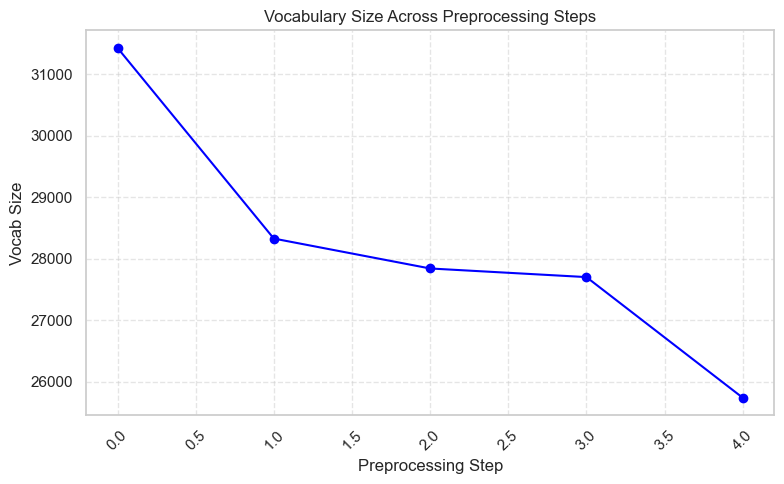

In [230]:
# Plot Vocab Size only
plt.figure(figsize=(8,5))
plt.plot(log_df.index, log_df['Vocab Size'], marker='o', color='blue')

plt.title("Vocabulary Size Across Preprocessing Steps")
plt.xlabel("Preprocessing Step")
plt.ylabel("Vocab Size")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Exploratory Data Analysis

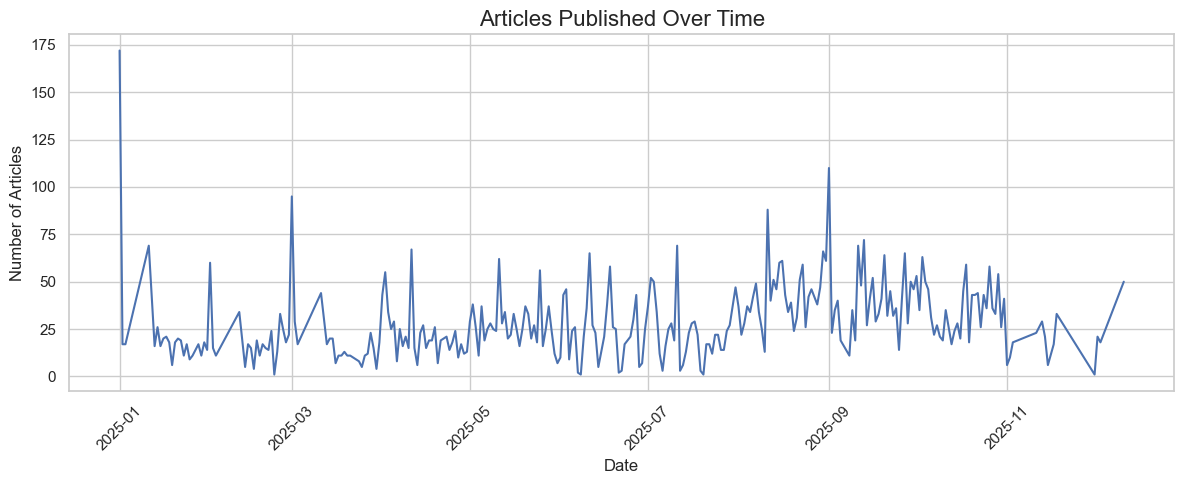

In [232]:
articles_per_day = df.groupby(df['Date'].dt.date).size()

plt.figure(figsize=(12, 5))
articles_per_day.plot(kind='line')

plt.title("Articles Published Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

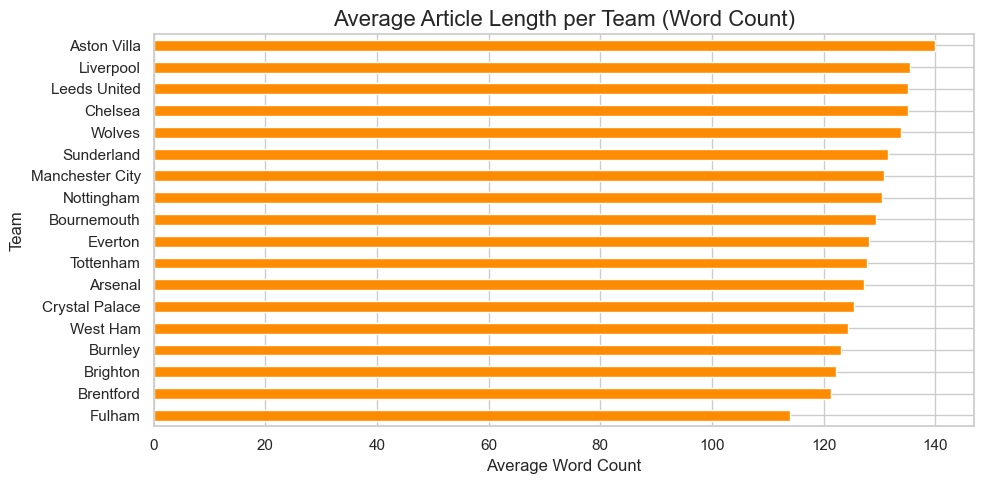

In [233]:
df['word_count'] = df['Tokens'].apply(len)
avg_length = df.groupby("Team")['word_count'].mean().sort_values()

plt.figure(figsize=(10, 5))
avg_length.plot(kind='barh', color='darkorange')

plt.title("Average Article Length per Team (Word Count)", fontsize=16)
plt.xlabel("Average Word Count", fontsize=12)
plt.ylabel("Team", fontsize=12)
plt.tight_layout()
plt.show()

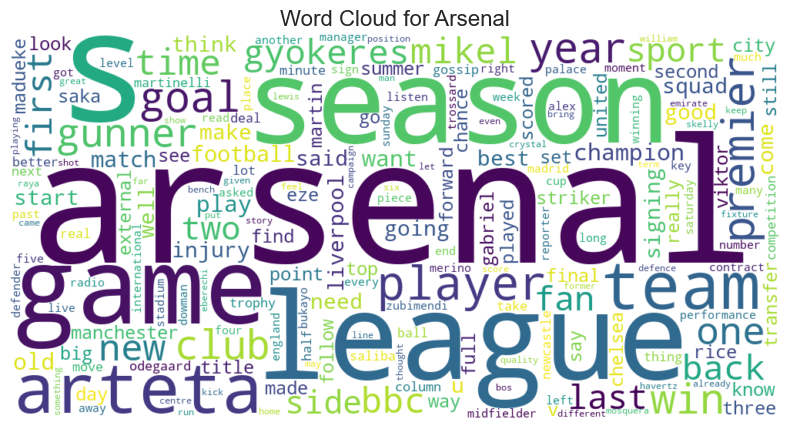

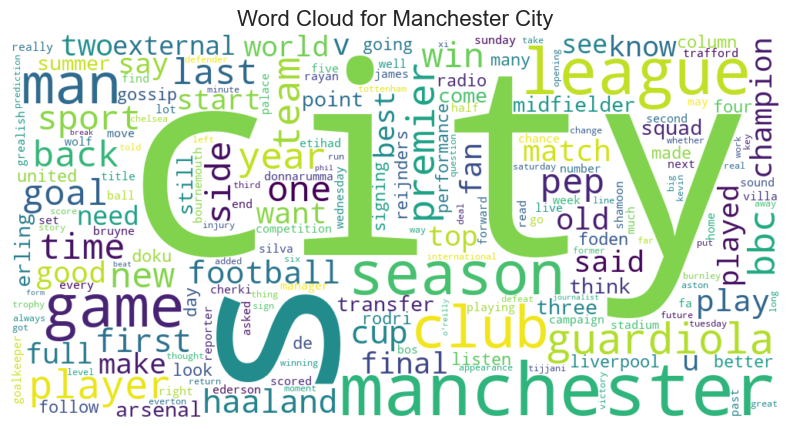

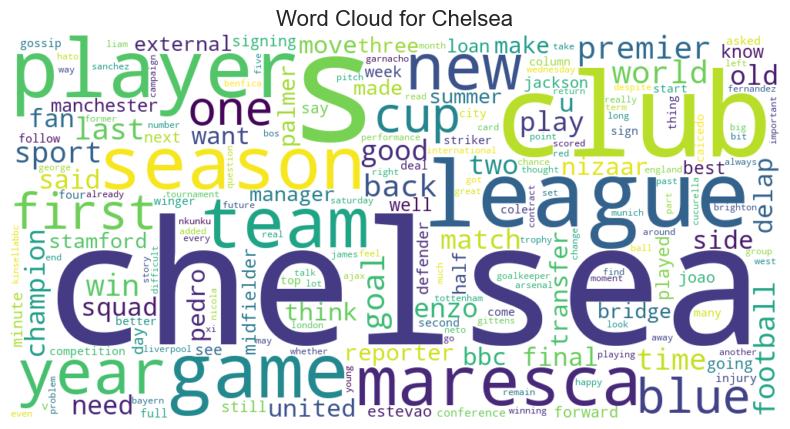

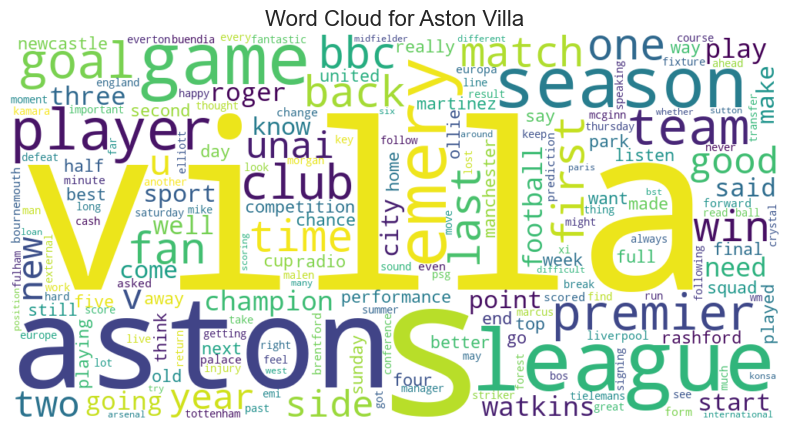

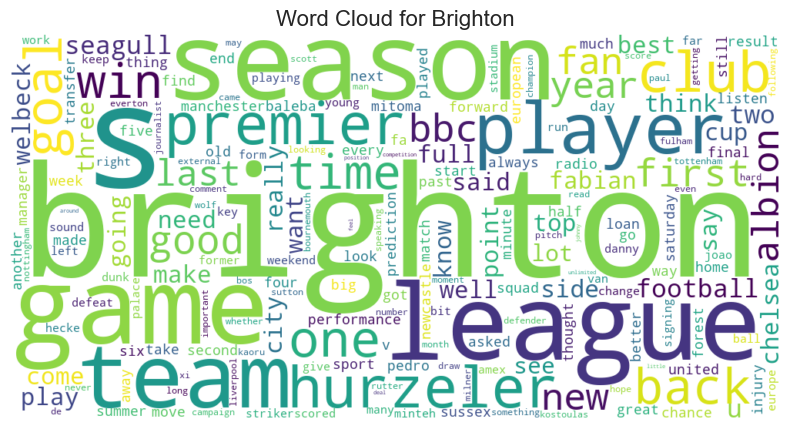

In [234]:
#WordCloud for the first 5 teams of the premier league
import seaborn as sns
from wordcloud import WordCloud

sns.set(style="whitegrid")

selected_teams = [
    "Arsenal",
    "Manchester City",
    "Chelsea",
    "Aston Villa",
    "Brighton"
]

valid_teams = [t for t in selected_teams if t in df['Team'].unique()]

for team in valid_teams:
    all_tokens = [
        token
        for tokens in df[df['Team'] == team]['Tokens']
        if isinstance(tokens, list)
        for token in tokens
    ]
    text = " ".join(all_tokens)
    
    wordcloud = WordCloud(
        width=1000,
        height=500,
        background_color="white",
        collocations=False
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {team}", fontsize=16)
    plt.show()

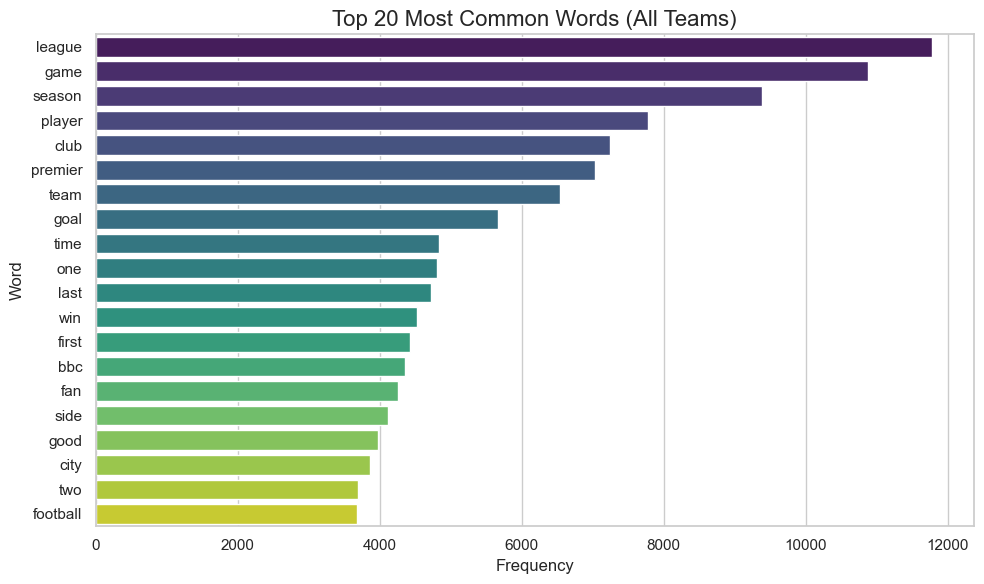

In [235]:
from collections import Counter

all_words = [
    token for tokens in df['Tokens']
    if isinstance(tokens, list)
    for token in tokens
    if token not in ["'s", "’s"]
]

word_counts = Counter(all_words).most_common(20)
words, counts = zip(*word_counts)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=list(counts),
    y=list(words),
    hue=list(words),   
    dodge=False,      
    legend=False,    
    palette="viridis"
)

plt.title("Top 20 Most Common Words (All Teams)", fontsize=16)
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()


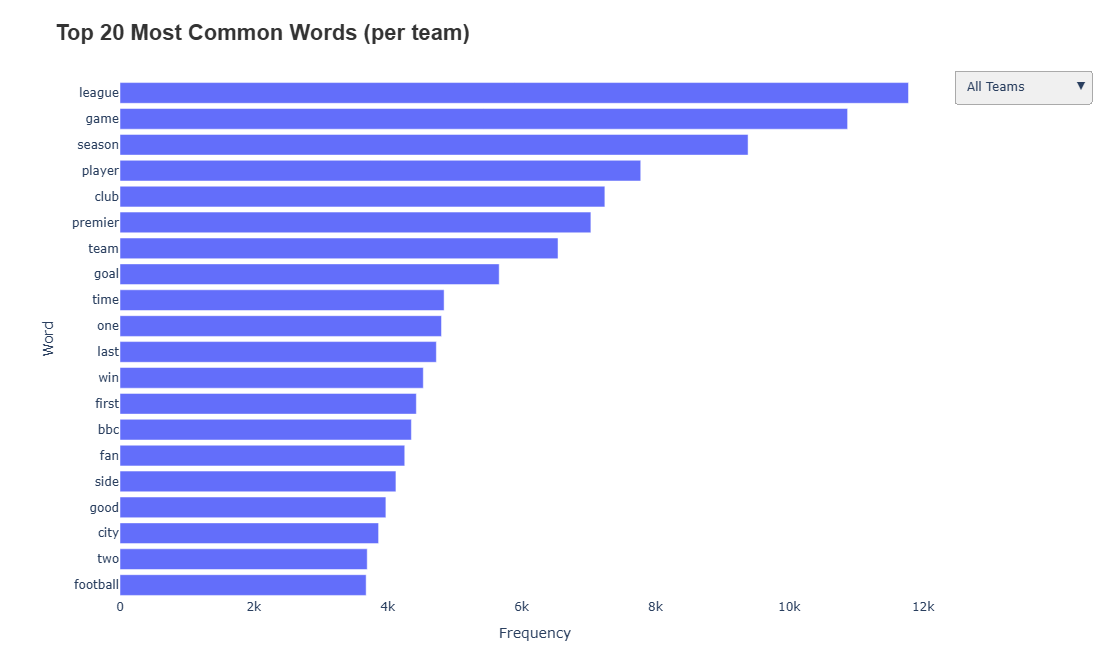

In [236]:
#Teams list
teams = ["All Teams"] + sorted(df["Team"].unique())

fig = go.Figure()

for team in teams:
    if team == "All Teams":
        tokens = [
            token
            for tokens in df["Tokens"]
            if isinstance(tokens, list)
            for token in tokens
            if token not in ["'s", "’s"]
        ]
    else:
        tokens = [
            token
            for tokens in df[df["Team"] == team]["Tokens"]
            for token in (tokens if isinstance(tokens, list) else [])
            if token not in ["'s", "’s"]
        ]

    #Most common 20 tokens
    word_counts = Counter(tokens).most_common(20)
    if len(word_counts) > 0:
        words, counts = zip(*word_counts)
    else:
        words, counts = [], []

    fig.add_trace(
        go.Bar(
            x=counts,
            y=list(words),
            name=team,
            orientation="h",
            visible=(team == "All Teams"),
        )
    )

fig.update_layout(
    title="<b>Top 20 Most Common Words (per team)</b>",
    title_font=dict(size=22, family="Arial", color="#333"),
    xaxis=dict(title="Frequency", title_font=dict(size=14)),
    yaxis=dict(title="Word", title_font=dict(size=14), autorange="reversed"),
    height=650,
    template="plotly_white",
    margin=dict(l=120, r=60, t=80, b=40),
    updatemenus=[
        dict(
            buttons=[
                dict(
                    label=team,
                    method="update",
                    args=[{"visible": [t == team for t in teams]}]
                )
                for team in teams
            ],
            direction="down",
            x=1.17,
            y=1.02,
            showactive=True,
            bgcolor="#F0F0F0",
            bordercolor="#AAA",
            borderwidth=1,
        )
    ],
)

fig.show()


### Merging the article data with the match data

In [238]:
#These are all the matches that have been completed in this season
len(data)

260

In [239]:
articles_by_team = {
    team: group.sort_values("Date")
    for team, group in df.groupby("Team")
}

In [240]:
def lookup_team_articles(team, match_date):
    if team not in articles_by_team:
        return ""
    
    team_articles = articles_by_team[team]
    
    # Ensure match_date is a Timestamp
    match_date = pd.to_datetime(match_date)
    
    # Calculate 30 days before the match
    start_date = match_date - pd.Timedelta(days=30)
    
    # Filter articles within 30 days before the match
    recent_articles = team_articles[
        (team_articles["Date"] >= start_date) & (team_articles["Date"] <= match_date)
    ]
    
    return " ".join(recent_articles["Text"].fillna("").tolist())

data["Team_Articles"] = data.apply(
    lambda row: lookup_team_articles(row["Team"], row["Date"]),
    axis=1
)

In [241]:
mask_articles_present = data['Team_Articles'].apply(lambda x: len(x) > 0)
data = data[mask_articles_present]

In [242]:
#Amount of rows we have after we dropped the rows with no articles
len(data)

234

In [243]:
data.head()

,MatchID,Date,Team,Opponent,HomeAway,xG_for,Score,Venue,Referee,Result,xG_prev,xG_last3,xG_last5,points_this_match,points_before_match,Team_Articles
0,1,2025-08-15,Liverpool,Bournemouth,1,2.2,4–2,Anfield,Anthony Taylor,Win,NaN,NaN,NaN,3,NaN,Liverpool turn attention to Ekitike after Isak...
1,1,2025-08-15,Bournemouth,Liverpool,0,1.7,4–2,Anfield,Anthony Taylor,Lose,NaN,NaN,NaN,0,NaN,First pictures of Vitality Stadium plans Bourn...
3,2,2025-08-16,Aston Villa,Newcastle Utd,1,0.2,0–0,Villa Park,Craig Pawson,Draw,NaN,NaN,NaN,1,NaN,Aston Villa draw pre-season friendly in United...
4,3,2025-08-16,Sunderland,West Ham,1,0.7,3–0,Stadium of Light,Robert Jones,Win,NaN,NaN,NaN,3,NaN,Sunderland 'still need strength in depth' Sund...
5,3,2025-08-16,West Ham,Sunderland,0,0.6,3–0,Stadium of Light,Robert Jones,Lose,NaN,NaN,NaN,0,NaN,West Ham launch 2025-26 away kit West Ham have...


### Applying the same preprocessing we did before on articles but this time in the article data that is in the merged dataset

In [245]:
tqdm.pandas()

#Uncontract function
def uncontract(text):
    text = str(text)
    text = re.sub(r"(\b)([Aa]re|[Cc]ould|[Dd]id|[Dd]oes|[Dd]o|[Hh]ad|[Hh]as|[Hh]ave|[Ii]s|[Mm]ight|[Mm]ust|[Ss]hould|[Ww]ere|[Ww]ould)n't", r"\1\2 not", text)
    text = re.sub(r"(\b)([Hh]e|[Ii]|[Ss]he|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'ll", r"\1\2 will", text)
    text = re.sub(r"(\b)([Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'re", r"\1\2 are", text)
    text = re.sub(r"(\b)([Ii]|[Ss]hould|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Ww]ould|[Yy]ou)'ve", r"\1\2 have", text)
    text = re.sub(r"(\b)([Cc]a)n't", r"\1\2n not", text)
    text = re.sub(r"(\b)([Ii])'m", r"\1\2 am", text)
    text = re.sub(r"(\b)([Ll]et)'s", r"\1\2 us", text)
    text = re.sub(r"(\b)([Tt]here)'s", r"\1\2 is", text)
    text = re.sub(r"(\b)([Ww])on't", r"\1\2ill not", text)
    text = re.sub(r"(\b)([Ss])han't", r"\1\2hall not", text)
    text = re.sub(r"(\b)([Yy])(?:'all|a'll)", r"\1\2ou all", text)
    return text

#Apply uncontract
data["Team_Articles"] = data["Team_Articles"].progress_apply(uncontract)

#Tokenization
data['Tokens'] = data['Team_Articles'].progress_apply(word_tokenize)

#Lowercase
data["Tokens"] = data["Tokens"].progress_apply(lambda toks: [t.lower() for t in toks])

#Remove punctuation and numbers
def remove_noise_tokens(tokens):
    cleaned = []
    for t in tokens:
        if all(c in string.punctuation for c in t):
            continue
        if t.isdigit():
            continue
        cleaned.append(t)
    return cleaned

data["Tokens"] = data["Tokens"].apply(remove_noise_tokens)

#Stopword removal
stop_words = set(stopwords.words('english'))
data['Tokens'] = data['Tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

#Lemmatization
lemmatizer = WordNetLemmatizer()
data['Tokens'] = data['Tokens'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])


100%|███████████████████████████████████████████████████████████████████████████████| 234/234 [00:00<00:00, 580.40it/s]


### Feature Engineering

In [247]:
#Creating sent_vader_neg, sent_vader_compound (overall sentiment), sent_blob_polarity, sent_blob_subjectivity
 
sia = SentimentIntensityAnalyzer()

#VADER SENTIMENT EXTRACTION
def vader_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return pd.Series([0,0,0,0])
    scores = sia.polarity_scores(text)
    return pd.Series([
        scores["neg"],
        scores["neu"],
        scores["pos"],
        scores["compound"]
    ])
 
data[["sent_vader_neg", "sent_vader_neu", "sent_vader_pos", "sent_vader_compound"]] = \
    data["Team_Articles"].progress_apply(vader_sentiment)

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [02:48<00:00,  1.39it/s]


In [248]:
def blob_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return pd.Series([0,0])
    blob = TextBlob(text)
    return pd.Series([blob.sentiment.polarity, blob.sentiment.subjectivity])
 
data[["sent_blob_polarity", "sent_blob_subjectivity"]] = \
    data["Team_Articles"].progress_apply(blob_sentiment)

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:21<00:00, 10.82it/s]


### EMOTION FEATURES using DepecheMood++

In [250]:
dm = pd.read_csv("DepecheMood_english_lemma_full.tsv", sep="\t")
dm.head()

,Unnamed: 0,AFRAID,AMUSED,ANGRY,ANNOYED,DONT_CARE,HAPPY,INSPIRED,SAD,freq
0,aa,0.005574,0.002948,0.012652,0.010860,0.194798,0.081419,0.685950,0.005800,40
1,aaa,0.171201,0.101690,0.068157,0.060415,0.082766,0.278729,0.205218,0.031824,59
2,aaaaah,0.003527,0.033237,0.049057,0.047942,0.168059,0.179710,0.458527,0.059941,3
3,aaaaahhhh,0.014169,0.290120,0.018033,0.192573,0.036304,0.389869,0.045984,0.012948,2
4,aaaaand,0.000000,0.051973,0.014261,0.685307,0.071774,0.007492,0.087275,0.081918,1


In [251]:
dm.rename(columns={"Unnamed: 0": "word"}, inplace=True)
dm = dm.sort_values("freq", ascending=False).drop_duplicates(subset=["word"])
emotion_categories = dm.columns[1:-1]   # all emotions except word + freq
dm_dict = dm.set_index("word")[emotion_categories].to_dict("index")

In [252]:
def get_emotion_scores(tokens):
    scores = defaultdict(float)
    count = 0
 
    for t in tokens:
        if t in dm_dict:
            for emo in emotion_categories:
                scores[emo] += dm_dict[t][emo]
            count += 1
 
    # Normalize
    if count > 0:
        for emo in emotion_categories:
            scores[emo] /= count
 
    return pd.Series(scores)
 
emotion_df = data["Tokens"].apply(get_emotion_scores)
data = pd.concat([data, emotion_df], axis=1)

### Keyword Events

- High injury_count - worse performance
- High uncertainty_count - unstable squad
- High transfer_count - distractions
- Coach changes - temporary instability or boost
- Suspensions - missing key players

In [254]:
event_keywords = {
    "injury": [
        "injury", "injured", "knock", "hamstring", "out", "ruled out",
        "doubt", "doubtful", "fitness concern", "sideline", "groin",
        "ankle", "knee", "calf", "muscle", "setback"
    ],
    "transfer": [
        "transfer", "linked", "deal", "contract", "signing",
        "bid", "offer", "loan", "move", "departure", "target",
        "release clause", "talks", "negotiation"
    ],
    "suspension": [
        "suspend", "suspension", "banned", "ban", "red card", "yellow card accumulation"
    ],
    "coach": [
        "manager", "coach", "tactical", "sack", "sacked",
        "appointment", "press conference", "training", "strategy"
    ],
    "uncertainty": [
        "might", "could", "may", "potentially", "risk",
        "unlikely", "expected", "uncertain", "questionable"
    ]
}


def compute_event_features(tokens):
    tokens = set(tokens)  
    results = {}
 
    for category, words in event_keywords.items():
        results[f"{category}_count"] = sum(1 for w in words if w in tokens)
 
    return pd.Series(results)

event_df = data["Tokens"].apply(compute_event_features)
data = pd.concat([data, event_df], axis=1)

In [255]:
len(data)

234

### Modeling

In [257]:
#Model without TF-IDF

#Our features to be used
X_cols = [
    'HomeAway', 'xG_prev', 'xG_last3', 'xG_last5', 'points_before_match',
    'sent_vader_neg', 'sent_vader_neu', 'sent_vader_pos', 'sent_vader_compound',
    'sent_blob_polarity', 'sent_blob_subjectivity',
    'AFRAID', 'AMUSED', 'ANGRY', 'ANNOYED', 'DONT_CARE', 'HAPPY', 'INSPIRED', 'SAD',
    'injury_count', 'transfer_count', 'suspension_count', 'coach_count', 'uncertainty_count'
]
y_col = 'Result'

#Select X and y, fill any NaNs with 0 
X = data[X_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
X = X.astype(float)   
y = data[y_col]

#Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

#Perform simple random split (85/15)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded, # 
    test_size=0.15,
    random_state=42,
    stratify=y_encoded
)

print(f"Total Training Rows: {len(X_train)}")
print(f"Total Testing Rows: {len(X_test)}")


#Scale features for SVM 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#Random Forest
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_names = le.inverse_transform(y_pred_rf)

print("Random Forest Metrics:")
print("-" * 25)
print(classification_report(le.inverse_transform(y_test), y_pred_rf_names, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


#XGBoost
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_names = le.inverse_transform(y_pred_xgb)

print("XGBoost Metrics:")
print("-" * 25)
print(classification_report(le.inverse_transform(y_test), y_pred_xgb_names, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


#SVM (Support Vector Machine)
svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_svm_names = le.inverse_transform(y_pred_svm)

print("SVM Metrics:")
print("-" * 25)
print(classification_report(le.inverse_transform(y_test), y_pred_svm_names, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))


#One-vs-Rest Logistic Regression
base_clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
ovr_clf = OneVsRestClassifier(base_clf, n_jobs=-1)

ovr_clf.fit(X_train, y_train)
y_pred_ovr = ovr_clf.predict(X_test)
y_pred_ovr_names = le.inverse_transform(y_pred_ovr)

print("OvR Logistic Regression Metrics:")
print("-" * 25)
print(classification_report(le.inverse_transform(y_test), y_pred_ovr_names, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ovr))

Total Training Rows: 198
Total Testing Rows: 36
Random Forest Metrics:
-------------------------
              precision    recall  f1-score   support

        Draw       0.17      0.14      0.15         7
        Lose       0.58      0.47      0.52        15
         Win       0.39      0.50      0.44        14

    accuracy                           0.42        36
   macro avg       0.38      0.37      0.37        36
weighted avg       0.43      0.42      0.42        36

Confusion Matrix:
 [[1 3 3]
 [0 7 8]
 [5 2 7]]
XGBoost Metrics:
-------------------------
              precision    recall  f1-score   support

        Draw       0.20      0.14      0.17         7
        Lose       0.67      0.53      0.59        15
         Win       0.47      0.64      0.55        14

    accuracy                           0.50        36
   macro avg       0.45      0.44      0.43        36
weighted avg       0.50      0.50      0.49        36

Confusion Matrix:
 [[1 3 3]
 [0 8 7]
 [4 1 9]]
SVM 

In [260]:
#Model with TF-IDF

data['Tokens_str'] = data['Tokens'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=100,
    stop_words='english',
    ngram_range=(1,2),
    min_df=2
)
tfidf_matrix = tfidf.fit_transform(data['Tokens_str'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"tfidf_{i}" for i in range(tfidf_matrix.shape[1])])

#Numeric features
X_numeric = data[X_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)

#Combine
X_full = pd.concat([X_numeric.reset_index(drop=True), tfidf_df], axis=1)
y = data[y_col]

#Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

#Split
X_train, X_test, y_train, y_test = train_test_split(
    X_full,
    y_encoded,
    test_size=0.15,
    random_state=42,
    stratify=y_encoded
)

print(f"Total Training Rows: {len(X_train)}")
print(f"Total Testing Rows: {len(X_test)}")

#Scale numeric + TF-IDF features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Random Forest
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Metrics:")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred_rf)))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

#XGBoost
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Metrics:")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred_xgb)))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

#SVM
svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
print("SVM Metrics:")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred_svm)))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

#One-vs-Rest Logistic Regression
base_clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
ovr_clf = OneVsRestClassifier(base_clf, n_jobs=-1)
ovr_clf.fit(X_train, y_train)
y_pred_ovr = ovr_clf.predict(X_test)
print("OvR Logistic Regression Metrics:")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred_ovr)))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ovr))

Total Training Rows: 198
Total Testing Rows: 36
Random Forest Metrics:
              precision    recall  f1-score   support

        Draw       0.29      0.29      0.29         7
        Lose       0.53      0.60      0.56        15
         Win       0.33      0.29      0.31        14

    accuracy                           0.42        36
   macro avg       0.38      0.39      0.39        36
weighted avg       0.41      0.42      0.41        36

Confusion Matrix:
 [[2 3 2]
 [0 9 6]
 [5 5 4]]
XGBoost Metrics:
              precision    recall  f1-score   support

        Draw       0.25      0.29      0.27         7
        Lose       0.59      0.67      0.62        15
         Win       0.36      0.29      0.32        14

    accuracy                           0.44        36
   macro avg       0.40      0.41      0.40        36
weighted avg       0.44      0.44      0.44        36

Confusion Matrix:
 [[ 2  3  2]
 [ 0 10  5]
 [ 6  4  4]]
SVM Metrics:
              precision    recall 

In [11]:
#XGBoost hyperparameter tuning

#Parameters to search
xgb_param_dist = {
    'n_estimators': [200, 500, 800, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.5],
    'scale_pos_weight': [1, 5, 10]
}

#XGBoost
xgb_clf = xgb.XGBClassifier(
    objective="multi:softprob",     
    num_class=3,
    eval_metric="mlogloss",
    random_state=42,
    enable_categorical=False,        
    tree_method="hist"           
)

#Hyperparameter tuning
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=xgb_param_dist,
    n_iter=50,
    cv=5,
    scoring='f1_weighted',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

#Using NumPy to avoid Pandas dtype warnings
xgb_random_search.fit(X_train.values, y_train)

#Best Parameters
print("\nBest XGBoost Parameters Found:")
best_xgb_params = xgb_random_search.best_params_
print(best_xgb_params)
print(f"Best CV Score (Weighted F1): {xgb_random_search.best_score_:.4f}")

#Train the model
best_xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    random_state=42,
    enable_categorical=False,
    tree_method="hist",
    **best_xgb_params
)

#Train using NumPy arrays to avoid dtype warnings
best_xgb_model.fit(X_train.values, y_train)


y_pred_xgb_tuned = best_xgb_model.predict(X_test.values)
y_pred_xgb_tuned_names = le.inverse_transform(y_pred_xgb_tuned)

print("\nOptimized XGBoost Metrics:")
print(classification_report(le.inverse_transform(y_test), y_pred_xgb_tuned_names, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb_tuned))


### Deep Learning Model

In [39]:
#!pip install tensorflow

## MLP

In [49]:
# One-hot encode target 
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)



model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(3, activation='softmax')  # 3 classes
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


# Train model
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train_cat,
    validation_split=0.2,
    epochs=300,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


# Evaluate model
y_pred_prob = model.predict(X_test_scaled)
y_pred_dl = np.argmax(y_pred_prob, axis=1)
y_pred_dl_names = le.inverse_transform(y_pred_dl)

print("\nDeep Learning Neural Network Metrics:")
print("-" * 40)
print(classification_report(le.inverse_transform(y_test), y_pred_dl_names, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dl))


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,635 (53.26 KB)

 Trainable params: 13,635 (53.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.2975 - loss: 1.1828 - val_accuracy: 0.3500 - val_loss: 1.1346
Epoch 2/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3165 - loss: 1.1268 - val_accuracy: 0.3750 - val_loss: 1.1118
Epoch 3/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4620 - loss: 1.0508 - val_accuracy: 0.3250 - val_loss: 1.0864
Epoch 4/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5380 - loss: 1.0373 - val_accuracy: 0.5250 - val_loss: 1.0383
Epoch 5/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4684 - loss: 1.0319 - val_accuracy: 0.3750 - val_loss: 1.0541
Epoch 6/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4873 - loss: 1.0171 - val_accuracy: 0.4500 - val_loss: 1.0438
Epoch 7/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4937 - loss: 0.9985 - val_accuracy: 0.4750 - val_loss: 1.0420
Epoch 8/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5127 - loss: 0.9796 - val_accuracy: 0.

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
